In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  FamilySize   418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


In [5]:
# 'Fare' feature의 missing value는 평균 값으로 대체
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

In [6]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

#### 데이터 분석 시 식에 로그를 취하는 이유
  - 1) 정규성을 높이고 분석에서 정확한 값을 얻기 위해
  - 2) 로그를 취하면 데이터 간 편차가 줄어들기 때문에 skewness와 kurtosis를 줄일 수 있어서 정규성이 높아짐
  - 참고 : https://leebaro.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D-%EC%8B%9C-%EC%8B%9D%EC%97%90-%EB%A1%9C%EA%B7%B8%EB%A5%BC-%EC%B7%A8%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0

In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,NaN,S,2


#### 'Name'에서 ,와 .사이에 있는 알파벳만 추출하는 정규 표현식

In [9]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

#### 추출한 Initial이 어떤 성별에 속하는지 확인 -> Sex와 Initial을 각각 테이블의 행과 열 값으로 사용
- 우선 여자와 남자가 같은 Initial을 사용하는 경우는 없음

In [10]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


#### 'Initial' 값들을 Miss, Mr, Mrs, Other, 총 4개의 대표 Initial로 변경

In [11]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

#### 여성과 관계된 title인 Miss, Mrs의 생존률(Survived)이 높은 것을 확인
- 이를 통해 구조 시 우선 순위에 있어서 여성이 남성보다 높았음을 예상할 수 있음

In [12]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,3.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,1.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,0.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,1.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,0.222222


#### 성별에 따른 생존률 시각화

<AxesSubplot:xlabel='Initial'>

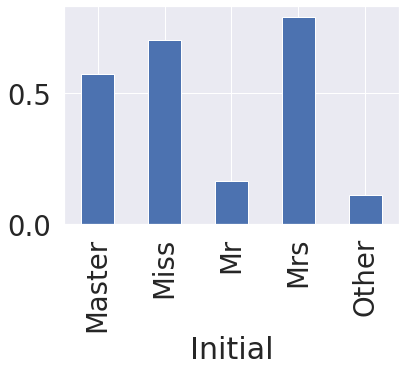

In [13]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- null을 채울 때 주의해야할 점은 train 데이터만 활용해야 한다는 점
- test 데이터는 언제나 unseen 상태로 놔둬야 하고, train 데이터 셋에서 얻은 statistics를 기반으로 train 및 test의 null 값을 채워줘야 함

In [14]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,3.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,1.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,0.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,1.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,0.222222


In [15]:
# Initial마다 출력된 평균 값(소수점 첫째 자리에서 반올림)을 null 값 대신 넣어줌
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [16]:
# 'Embarked' feature에도 결측치 존재함
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


In [17]:
# 결측치를 최빈값인 'S'로 대체 
df_train['Embarked'].fillna('S', inplace=True)

In [18]:
# continuous feature를 categorical feature로 변경하면 정보가 손실될 수도 있음
# 1) loc : 데이터프레임의 indexing 방법
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[(70 <= df_train['Age']), 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[(70 <= df_test['Age']), 'Age_cat'] = 7

In [19]:
# 2) apply : 함수 작성 후, 이를 데이터프레임에 적용
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [20]:
print('1번 방법, 2번 방법 둘 다 같은 결과를 내면 True가 반환됨 ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘 다 같은 결과를 내면 True가 반환됨 -> True


In [21]:
# 필요없는 컬럼 삭제
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

#### 카테고리형 변수 값을 문자열에서 정수형으로 mapping

In [23]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [24]:
# 'Embarked' 컬럼에 속한 데이터 값들을 중복 없이 출력
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [25]:
# 데이터 값마다 몇 개의 레코드 있는지 출력
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [26]:
# Embarked의 데이터 값을 string에서 integer로 mapping
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [27]:
# check missing values
df_train['Embarked'].isnull().any()

False

In [28]:
df_train['Embarked'].unique()

array([2, 0, 1])

In [29]:
# Sex의 데이터 값도 string에서 integer로 변경
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

In [30]:
df_train['Sex'].unique()

array([1, 0])

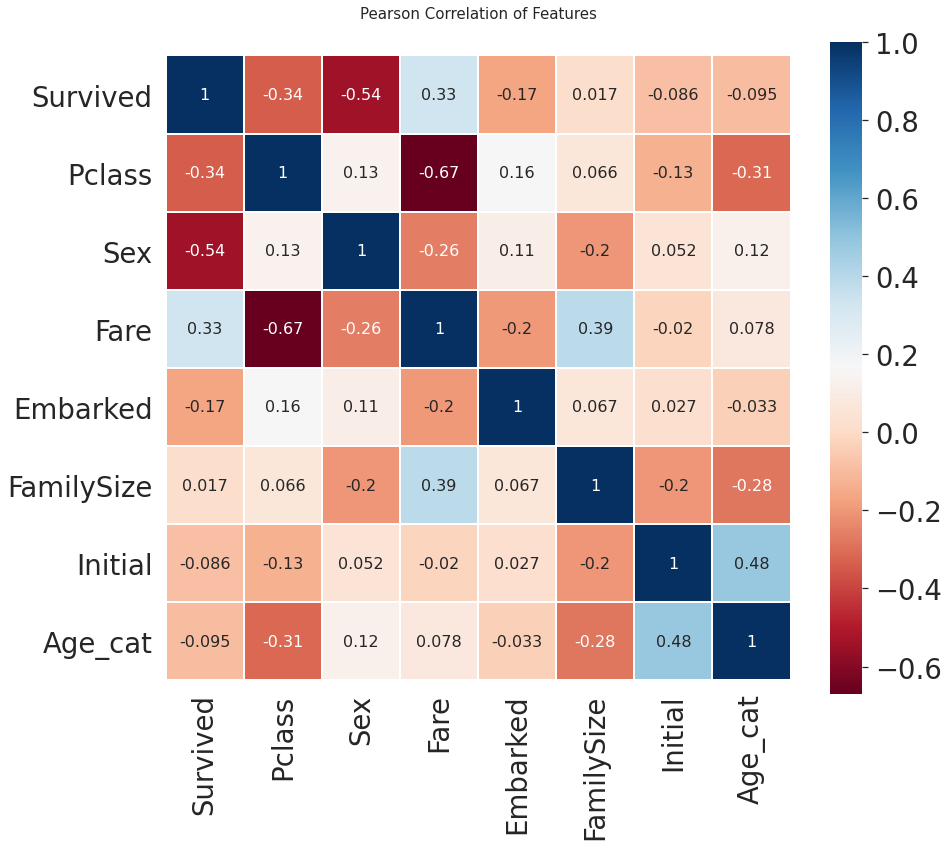

In [31]:
# feature 간 피어슨 상관관계를 알아보기 위해 feature 선택 (숫자형이어야 함)
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16})

del heatmap_data

-  위 heatmap을 살펴보면 서로 강한 상관관계를 갖는 features가 없다는 것을 알 수 있다.
-  이는 모델을 학습시킬 때 불필요한 (redundant, superfluous) feature가 없음을 의미한다.
-  왜냐면 서로 강한 상관관계의 feature A, B가 있다면 두 features(A, B)와 다른 features 간의 상관관계는 의미가 없기 때문이다.

### 수치화된 데이터를 가변수화하여 표시(get_dummies)
- 이전에 object 타입의 데이터를 정수 타입으로 변경했다.
- 이를 다시 가변수화하여 나타내면 기계학습에 적합한 데이터의 형태가 된다.
- dummy(=서로 무관한 수)로 가변수화 해주는 이유는, 단순히 정수 즉, 수치형 데이터로만 바꾸면 서로 간의 관계성이 생기기 때문
- 예를 들어 'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4 라고 했을 때, Miss(1) + Mr(2) = Mrs(3) 이라는 관계성이 존재하게 됨.
- 하지만 실제 데이터엔 그러한 관계성이 없음. 이러한 이유로 잘못된 학습이 일어날 수 있음
- 따라서 수치형 데이터의 독립성을 표현하기 위해 get_dummies를 사용하고, 이를 통해 데이터를 one-hot encoding 형태로 표현할 수 있게 됨

In [32]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [33]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,1,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,1,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,0,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,1,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,0,3,0,0,1,0,0


In [34]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [35]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [36]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,1,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,1,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,0,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,1,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,0,3,0,0,1,0,0,0,0,1


In [37]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,0,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,1,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,0,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,0,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,2,2,0,0,0,1,0,0,0,1


- test data의 경우, 해당 데이터를 입력하면 'Survived'를 예측한 결과를 내기 때문에 'Survived' column이 없음

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [40]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

### train_test_split() : 전체 데이터 셋 배열을 받아 랜덤하게 test, train 데이터 셋으로 분리하는 함수
- test_size : 테스트 데이터 셋의 비율
- random_state : 데이터 분할 시 셔플이 이루어지는데, 이를 위한 시드 값
- shuffle : 셔플 여부 결정 (default=True)

In [41]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- 앞서 모델 객체를 생성했다면, fit 메소드로 모델을 학습시키게 됨
- 이후 valid set input을 넣어서 예측값(X_vld sample(탑승객)의 생존여부)을 얻게 됨

In [42]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [43]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.58% 정확도로 생존을 맞춤


In [44]:
prediction

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1])

In [45]:
y_vld

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1])

In [46]:
y_vld.shape

(268,)

In [48]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

### 학습된 모델이 어떤 feature에 의해 영향을 많이 받았는지 알 수 있는 지표 'feature importance'

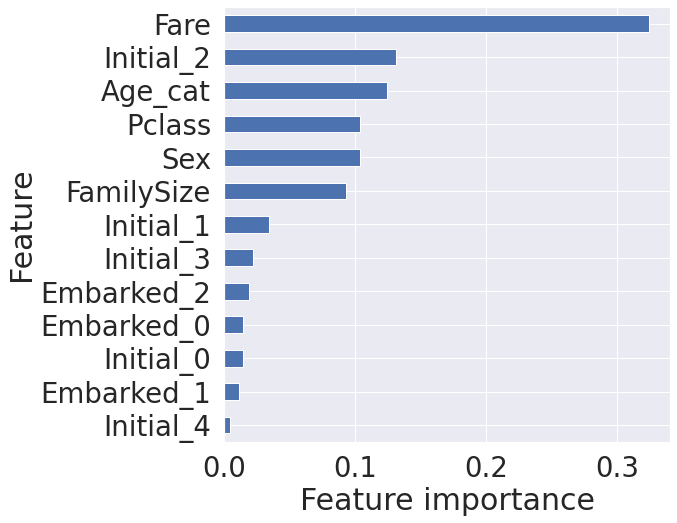

In [49]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [50]:
submission = pd.read_csv('./input/gender_submission.csv')

In [51]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [52]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [53]:
submission.to_csv('./my_first_submission(1).csv', index=False)

In [54]:
X_test.shape

(418, 13)

In [55]:
prediction.shape

(418,)